In [1]:
# make a stripplot:
# - pkr variants to k3l-wt
# - k3l variants to pkr-wt

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['savefig.dpi'] = 300
plt.rcParams["figure.figsize"] = (10,5)
import seaborn as sns
from matplotlib.colors import LogNorm, Normalize
from scipy import stats 

In [3]:
df = pd.read_csv('../data/barseq_counts.csv')

#df['pkr'] = df['var'].str.split('_').str[0]
#df['k3l'] = df['var'].str.split('_').str[1]

# down-select for K3L-NULL and K3L-WT
def k3l_type(row, k3l_stop=60):
    x = row['k3l'].split('-')[1]
    if x == 'WT':
        return 'K3L-WT'
    elif x[-1] == '*' and int(x[1:-1]) < k3l_stop:
        return 'K3L-STOP' 
    else:
        return 'K3L-VAR'
df['k3l_type'] = df.apply(lambda x: k3l_type(x), axis=1)

def pkr_type(row, pkr_stop = 550):
    x = row['pkr'].split('-')[1]
    if x == 'WT':
        return "PKR-WT"
    elif x == 'D486V':
        return "PKR-D486V"
    elif x[-1] == "*" and int(x[1:-1]) < pkr_stop:
        return "PKR-STOP"
    else:
        return np.nan
df['pkr_type'] = df.apply(lambda x: pkr_type(x), axis=1)

# normalize read count
sample_list = ['1','2','3','4','5','6']
for sample in sample_list:
    df[f'{sample}_norm'] = df[sample]/df[sample].sum()

# fold change
for t0,t1 in zip([1,2,3],[4,5,6]):
    df[f'fc_{t0}'] = df[f'{t1}_norm'] / df[f'{t0}_norm']

# log2_fc
for i in [1,2,3]:
    df[f'log2_fc_{i}'] = np.log2(df[f'fc_{i}'])

cols = ['log2_fc_1','log2_fc_2','log2_fc_3']
df['mean_fc'] = df[cols].mean(axis=1)

# THRESHOLD: take only measures with >10 reads at TP-0
# this could be better
cols = ['1','2','3']
df['mean_reads_0hr'] = df[cols].mean(axis=1)
df = df.query('mean_reads_0hr >= 10')

In [4]:
# select variants paired with WT
df = df.query('k3l_type == "K3L-WT" or pkr_type == "PKR-WT"')

In [5]:
variant_map = {True:'PKR Variants', False:'K3L Variants'}
df['variants'] = df['k3l_type'] == "K3L-WT"
df['variants'] = df['variants'].map(variant_map)

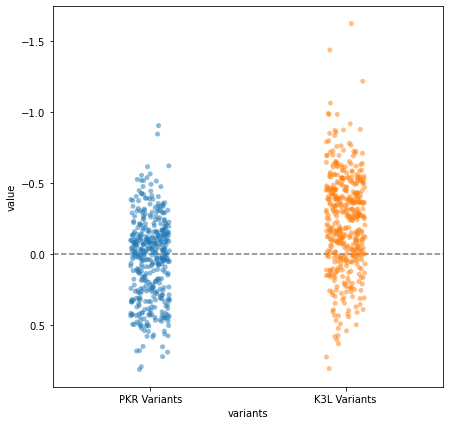

In [35]:
plt.rcParams["figure.figsize"] = (7,7)
df_melt = df.melt(['var','variants'],'mean_fc')
g=sns.stripplot(x='variants',y='value',data=df_melt, alpha=.5)
g.axhline(0, color='gray', linestyle='--')
g.invert_yaxis()

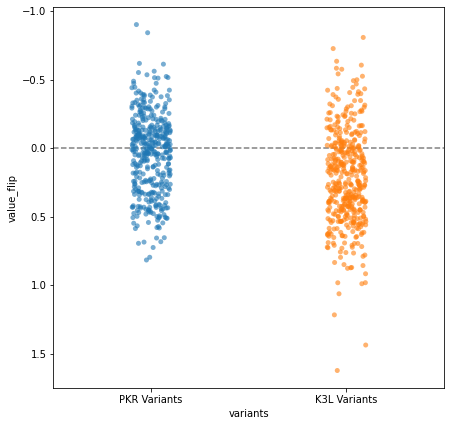

In [38]:
plt.rcParams["figure.figsize"] = (7,7)
# technically shouldn't flip the variants, but doing it for simplicity
def flip_k3l(row):
    if row.variants == "K3L Variants":
        return -(row.value)
    else:
        return row.value
    
df_melt['value_flip'] = df_melt.apply(lambda x: flip_k3l(x), axis=1)

g=sns.stripplot(x='variants',y='value_flip',data=df_melt, alpha=.6)
g.axhline(0, color='gray', linestyle='--')
g.invert_yaxis()

In [12]:
df.groupby('variants')['mean_fc'].mean()

variants
K3L Variants   -0.220402
PKR Variants    0.037300
Name: mean_fc, dtype: float64

In [21]:
# check if the difference is significant, YES
k3l_variant_mean_fc = df.query('variants == "K3L Variants"').mean_fc.tolist()
pkr_variant_mean_fc = df.query('variants == "PKR Variants"').mean_fc.tolist()

stats.ttest_ind(k3l_variant_mean_fc, pkr_variant_mean_fc,nan_policy='omit')[1]

7.897277186875916e-30

<AxesSubplot:xlabel='variants', ylabel='value_flip'>

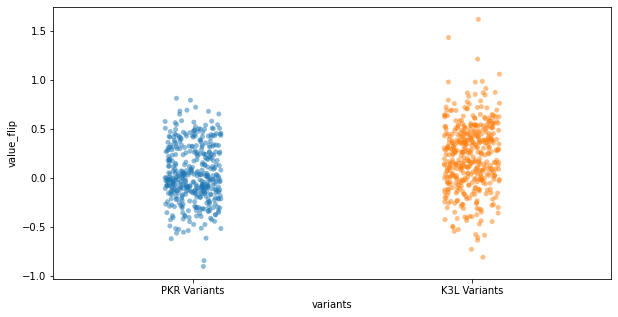

In [6]:
df['pkr_variant'] = df['var'].str.split('_').str[0]
df['site'] = df.pkr_variant.str.split('-').str[1].str[1:-1]

In [7]:
# fold change p-values between the three replicates
cols = [f"fc_{i}" for i in [1,2,3]]
def fold_ttest(row):
    fc_array = row[cols].tolist()
    return stats.ttest_ind([0,0,0], fc_array, nan_policy='omit')[1]
df['fc_p'] = df.apply(fold_ttest, axis=1)

In [10]:
df['-log10_fc-pvalue'] = -np.log10(df['fc_p'])

<AxesSubplot:xlabel='mean_fc', ylabel='-log10_fc-pvalue'>

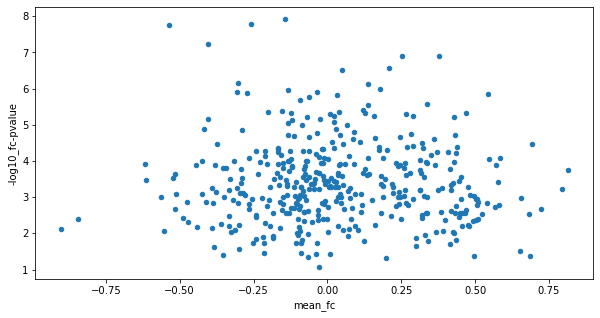

In [13]:
df.plot.scatter(x='mean_fc', y='-log10_fc-pvalue')

In [14]:
-np.log10(.05)

1.3010299956639813

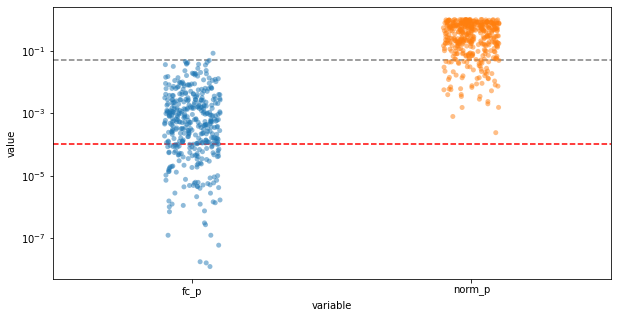

In [27]:
# pkr vs k3l-wt p-values for fc and norm
temp_df = df.query('k3l == "K3L-WT"')
melt_df = temp_df.melt(id_vars='var', value_vars=['fc_p','norm_p'])
g = sns.stripplot(
    data=melt_df,
    y = 'value',
    x = 'variable',
    alpha=.5,
    dodge=True
)
plt.yscale('log', base=10)
g.axhline(.05, color='gray', linestyle='--')
g.axhline(.0001, color='red', linestyle='--')

In [ ]:
g.axhline(.05, color='gray', linestyle='--')
g.axhline(.0001, color='red', linestyle='--')

g.set_title('Comparison of p-values across replicates')
g.set_xlabel('p-value category')
g.set_ylabel('p-value')
sns.set(rc={'figure.figsize':(10,5)})
fig = g.get_figure()
fig.savefig('../img/pkr-k3l-wt_p-value-spread.png')

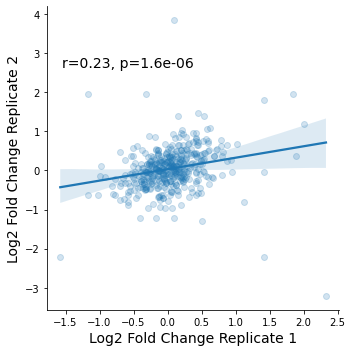

In [46]:
x = 'log2_fc_1'
y = 'log2_fc_2'

temp_df = df.query('k3l == "K3L-WT"')
temp_df = temp_df[[x,y]].dropna()
g = sns.lmplot(x=x, y=y, data=temp_df, scatter_kws={'alpha':0.2})

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p), fontsize=14,
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
g.set_xlabels('Log2 Fold Change Replicate 1', fontsize=14)
g.set_ylabels('Log2 Fold Change Replicate 2', fontsize=14)

#fig = g.get_figure()

plt.tight_layout()
g.savefig('../img/xy-replication.pdf')

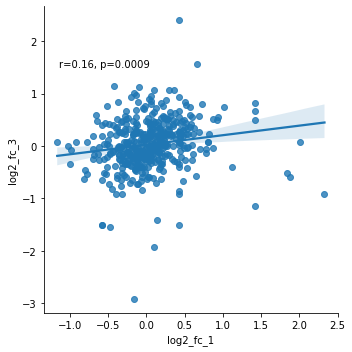

In [31]:
x = 'log2_fc_1'
y = 'log2_fc_3'

temp_df = df.query('k3l == "K3L-WT"')
temp_df = temp_df[[x,y]].dropna()
g = sns.lmplot(x=x, y=y, data=temp_df)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()

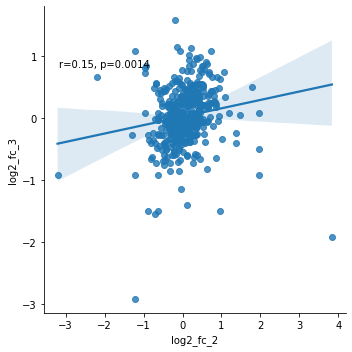

In [32]:
x = 'log2_fc_2'
y = 'log2_fc_3'

temp_df = df.query('k3l == "K3L-WT"')
temp_df = temp_df[[x,y]].dropna()
g = sns.lmplot(x=x, y=y, data=temp_df)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data[x], data[y])
    ax = plt.gca()
    ax.text(.05, .8, 'r={:.2f}, p={:.2g}'.format(r, p),
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.show()